In [1]:
import tensorflow as tf

from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK, STATUS_FAIL

from pickle import dump, load
import gzip

import numpy as np
import pandas as pd
from scipy.stats import binned_statistic as binStats

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns

from os import popen


#bug? On lab machines quibo import fails requiring at least version 2.2.0, but tf version is 2.10.0
try:
    import qibo
except RuntimeError:
    tfvers = tf.__version__
    print(f"Modified tensorflow version while importing qibo (tf.__version__ = {tfvers})")
    tf.__version__ = "2.9.0"
    import qibo
    tf.__version__ = tfvers

from qibo import models, gates

___

In [2]:
RANDSEED = 42

In [3]:
plt.rcParams.update({'figure.figsize': [15.0, 10.0],
                     'figure.dpi' : 300,
                     'font.size': 18.0, 
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

qibo.set_backend("numpy")

[Qibo 0.2.2|INFO|2024-01-14 23:24:51]: Using numpy backend on /CPU:0


___
# Load Datasets

In [5]:
#datasetName = "testDataset_1dim"
datasetName = "testDataset_2dim"

#datasetName = "housing"
#datasetName = "housing_lessFeatures"

#datasetName = "cars_v3"
#datasetName = "cars_v3_lessFeatures"


X_train, y_train, X_val, y_val, X_test, y_test, INPUT_SHAPE = load(gzip.open(f"DatasetsProcessed/{datasetName}", "rb"))


nFeatures = 1
for i in INPUT_SHAPE:
        nFeatures *= i

___
# Hyperparameters Optimization

In [ ]:
################# Create circuit model with architecture determined by "ansatzType", and variable number of layers and gate repeats #################

def makeCircuitAnsatz(layers, nFeatures, ansatzType, repeats):
    #each circuit "unit" is repeated layers times
    #each parametrized gate in the unit is repeated repeats times (probably similar effect to adding layers)
    
    if ansatzType == "linear":
    # circuit "unit": -RZ-H-RY-H- * nFeatures
    # RZ theta = a + b * x_i
    # RY theta = c
        c = models.Circuit(1)
        
        c.add(gates.H(0))
        for _ in range(layers):
            for _ in range(nFeatures):
                for _ in range(repeats):
                    c.add(gates.RZ(0, theta=0))
                    c.add(gates.H(0))
                    c.add(gates.RY(0, theta=0))
                    c.add(gates.H(0))
                    
        c.add(gates.M(0))
        
        params_shape = (layers, nFeatures, repeats, 3,)
        
  
    elif ansatzType == "abs":
    # like a linear ansatz architecture, but the gates are parametrized differently:
    # RZ theta = a + b * |x-c|
    # RY theta = d
    # (idea is to make the model easily gain "peak" sensibility to certain range in data input)
        c = models.Circuit(1)
        c.add(gates.H(0))
        
        for _ in range(layers):
            for _ in range(nFeatures):
                    for _ in range(repeats):
                        c.add(gates.RZ(0, theta=0))
                        c.add(gates.H(0))
                        c.add(gates.RY(0, theta=0))
                        c.add(gates.H(0))
        c.add(gates.M(0))
        
        params_shape = (layers, nFeatures, repeats, 4,)

        
    elif ansatzType == "2qubits":
    # circuit "unit" (output is read on qubit 0)
    #     -----------CRZ-H-CRY-H-
    #                 |     |      * nFeatures
    #     -RZ-H-RY-H--o-----o----
    #
    # gates in 2nd qubit are parametrized like: thetaRZ = a + b * x_i, thetaRY = c + d * x_i
    # controlled gates in 1st qubit are not dependent on input x: thetaCRZ = e, thetaCRY = f
        c = models.Circuit(2)
        for _ in range(layers):
            for _ in range(nFeatures):
                for _ in range(repeats):
                    c.add(gates.RZ(1, theta=0))
                    c.add(gates.H(1))
                    c.add(gates.RY(1, theta=0))
                    c.add(gates.H(1))
            for _ in range(repeats):
                c.add(gates.CRZ(1,0,theta=0))
                c.add(gates.H(0))
                c.add(gates.CRY(1,0,theta=0))
                c.add(gates.H(0))
        c.add(gates.M(0))
        
        params_shape = (layers, nFeatures+1, repeats, 4,)
        
    
    else:
        raise NotImplementedError(f"No implementation for ansatzType={ansatzType}")
        
    return c, params_shape





################# Precalculate circuit parameters for each element of the dataset #################

def getCircuitParameters(params, X, nFeatures, layers, ansatzType, repeats):
    
    parList = []
    
    if ansatzType == "linear":
        for l in range(layers):
            for f in range(nFeatures):
                for r in range(repeats):
                    parList.append(params[l,f,r,0] + params[l,f,r,1]*X[:,f])
                    parList.append(params[l,f,r,2]*np.ones(X.shape[0]))
                
    elif ansatzType == "abs":
        for l in range(layers):
            for f in range(nFeatures):
                for r in range(repeats):
                    parList.append(params[l,f,r,0] + params[l,f,r,1]*np.abs(X[:,f]-params[l,f,r,2]))
                    parList.append(params[l,f,r,3]*np.ones(X.shape[0]))

    elif ansatzType == "2qubits":
        for l in range(layers):
            for f in range(nFeatures):
                for r in range(repeats):
                    parList.append(params[l,f,r,0] + params[l,f,r,1]*X[:,f])
                    parList.append(params[l,f,r,2] + params[l,f,r,3]*X[:,f])
            for r in range(repeats):
                parList.append(params[l,nFeatures,r,0]*np.ones(X.shape[0]))
                parList.append(params[l,nFeatures,r,1]*np.ones(X.shape[0]))

    else:
        raise NotImplementedError(f"No implementation for ansatzType={ansatzType}")      
    
    return np.stack(parList, axis=-1)





################# Predict target values for data X #################

def predict(X, params, nFeatures, ansatzType, layers, repeats):
    y_pred = []
    circuit, parShape = makeCircuitAnsatz(layers, nFeatures, ansatzType, repeats)
    par = params.reshape(parShape)
    circuitParams = getCircuitParameters(par, X, nFeatures, layers, ansatzType, repeats)
    for i,x in enumerate(X):
        state = circuit.set_parameters(circuitParams[i])
        prob = circuit(nshots=1024).probabilities([0])
        y_pred.append(0.5 * (prob[0] - prob[1] + 1)) #target values are in [0,1] --> using as prediction 0.5 * (prob[|0>] - prob[|1>] + 1)
    return y_pred




################# Compute loss for given data and model architecture #################

def loss(params, circuit, X, y, nFeatures, layers, ansatzType, repeats, params_shape, verbose=0): 
    modelParams = params.reshape(params_shape)
    circuitParams = getCircuitParameters(modelParams, X, nFeatures, layers, ansatzType, repeats)
    loss = 0
    for par,y_single in zip(circuitParams,y):
        circuit.set_parameters(par)
        prob = circuit.execute(nshots=1).probabilities([0])
        y_pred = 0.5 * (prob[0] - prob[1] + 1) #using 
        loss += (y_pred - y_single) ** 2
        
    loss /= len(y)
    if verbose > 0:
        print(f"Computed Loss    ---    loss={loss}", flush=True)
        
    return loss




################# Train model with given architecture #################

def train(X_train, y_train, layers, ansatzType, nFeatures, repeats, epochs):
    circuit, params_shape = makeCircuitAnsatz(layers, nFeatures, ansatzType, repeats)
    params_init = np.random.sample(params_shape)
    hist_par = []
    _, parameters, _ = qibo.optimizers.optimize(loss,
                                                params_init.flatten(),
                                                args=(circuit, X_train, y_train, nFeatures, layers, ansatzType, repeats, params_shape),
                                                method='parallel_L-BFGS-B', options={'maxiter':epochs, 'disp':1},
                                                callback=hist_par.append
                                               )
    return parameters, hist_par




################# Train multiple models to find optimal hyperparameters #################

#Training is too slow: only use part of the training data for each hyperparameter trial
class BatchManagerWrapper:
    def __init__(self, i_start, batch_size, Xtrain, ytrain, Xval, yval, nFeatures):
        self._i = i_start
        self._batch_size = batch_size
        self._Xtrain = Xtrain
        self._ytrain = ytrain
        self._Xval = Xval
        self._yval = yval
        
    def hyperopt_func(self, hyperParams):
        layers = int(hyperParams["layers"])
        ansatzType = hyperParams["ansatzType"]
        repeats = int(hyperParams["repeats"])
        epochs = 25

        print(f"Training Model with :\n\t- {layers} hidden layers\n\t- {repeats} repeats\n\t- ansatz = {ansatzType}\n\n")

        try:
            maxidx = len(self._ytrain)
            start = (self._i*self._batch_size)%maxidx
            end = ((self._i+1)*self._batch_size)%maxidx
            if start < end:
                Xtr = self._Xtrain[start:end]
                ytr = self._ytrain[start:end]
                #print(f"BATCH [{start}:{end}] - ", end='')
            else:
                Xtr = np.concatenate((self._Xtrain[start:], self._Xtrain[:end]), axis=0)
                ytr = np.concatenate((self._ytrain[start:], self._ytrain[:end]), axis=0)
                #print(f"BATCH [{start}:] + [:{end}] - ", end='')
            maxidx_val = len(self._yval)
            start_val = (self._i*self._batch_size)%maxidx_val
            end_val = ((self._i+1)*self._batch_size)%maxidx_val
            if start_val < end_val:
                Xv = self._Xval[start_val:end_val]
                yv = self._yval[start_val:end_val]
                #print(f"BATCH_VAL [{start_val}:{end_val}]\n\n")
            else:
                Xv = np.concatenate((self._Xval[start_val:], self._Xval[:end_val]), axis=0)
                yv = np.concatenate((self._yval[start_val:], self._yval[:end_val]), axis=0)
                #print(f"BATCH_VAL [{start_val}:] + [:{end_val}]\n\n")


            bestParams, params_hist = train(Xtr, ytr, layers, ansatzType, nFeatures=nFeatures, repeats=repeats, epochs=epochs)

            model, params_shape = makeCircuitAnsatz(layers, nFeatures, ansatzType, repeats)
            val_loss = loss(bestParams, model, Xv, yv, nFeatures, layers, ansatzType, repeats, params_shape)

            self._i += 1

            print(f"\nTraining successful: loss={val_loss:.5f}\n\n\n")

            return {"loss" : val_loss, "status" : STATUS_OK, "bestParams" : [bestParams], "history" : [{"params_hist" : params_hist}]}

        except KeyboardInterrupt:
            raise KeyboardInterrupt

        except:
            print("Training Failed, next trial\n\n\n")
            return {"status" : STATUS_FAIL}

In [ ]:
search_space = {
#    "layers" : hp.quniform("layers", 2, 10, 1),
#    "ansatzType" : hp.choice("ansatzType", ["linear", "abs", "2qubits"]),
#    "repeats" : hp.quniform("repeats", 1, 5, 1),
    "layers" : 5,
    "ansatzType" : "linear",
    "repeats" : 5

}

In [ ]:
BATCH_SIZE = 500
TOT_TRIALS = 1

# Start a new hyperparameter search (overwrites old trials!!)
trials = Trials()
# or resume previous one
#trials = load(gzip.open(f"Variables/QML_Trials/hp_trials_QML_{datasetName}", "rb"))

batchManager = BatchManagerWrapper(len(trials.trials), BATCH_SIZE, X_train, y_train, X_val, y_val, nFeatures)
for i in range(len(trials.trials)+1, TOT_TRIALS+1):
    print(f"-------------------    TRIAL {i}/500    -------------------\n\n")
    fmin(batchManager.hyperopt_func, search_space, algo=tpe.suggest, max_evals=i, trials=trials, show_progressbar=False)
    
    save_every_Nrounds = 2
    if i==1 or i%save_every_Nrounds==0:
        print("-----------------------------------------------------------\n\n")
        print("Dumping trials... don't ctrl-c now...", end='')
        dump(trials, gzip.open(f"Variables/QML_Trials/hp_trials_QML_{datasetName}", "wb"))
        print(" Done!\n\n")

-------------------    TRIAL 1/500    -------------------


Training Model with :
	- 5 hidden layers
	- 5 repeats
	- ansatz = linear


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          150     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35555D-01    |proj g|=  3.63923D-02


 This problem is unconstrained.



At iterate    1    f=  1.14864D-01    |proj g|=  3.58257D-02

At iterate    2    f=  8.93926D-02    |proj g|=  2.84104D-02

At iterate    3    f=  6.48700D-02    |proj g|=  2.13728D-02

At iterate    4    f=  5.46837D-02    |proj g|=  1.61347D-02

At iterate    5    f=  4.71665D-02    |proj g|=  1.58729D-02


## Hyperparameters search results

In [11]:
#Load trials, get best hyperparameters, trained model and training history
def trials_to_DataFrame(trials_list, search_space=search_space, 
                        trials_columns=['loss', 'layers', 'repeats', 'ansatzType', "bestParams", "history"], 
                        columns_new_names = ["Loss", "Layers","Repeats", "Type of Ansatz Circuit", "bestParams", "history"]):

    trials_df_list = []
    for trials in trials_list:
        def unpack(x):
            try:
                return x[0]
            except:
                return x


        lossTrials = pd.DataFrame([trial["result"]["loss"] for trial in trials.trials if trial["result"]["status"] == STATUS_OK], columns=["loss"])
        weightsTrials = pd.DataFrame([trial["result"]["bestParams"] for trial in trials.trials if trial["result"]["status"] == STATUS_OK], columns=["bestParams"])
        historyTrials = pd.DataFrame([trial["result"]["history"] for trial in trials.trials if trial["result"]["status"] == STATUS_OK], columns=["history"])
        paramsTrials = pd.DataFrame([trial["misc"]["vals"] for trial in trials.trials if trial["result"]["status"] == STATUS_OK]).applymap(unpack)
        paramsTrials = paramsTrials.T.apply(lambda x: space_eval(search_space, x))
        paramsTrials = pd.DataFrame.from_records(paramsTrials.values)

        trials_df = pd.concat([lossTrials, paramsTrials, weightsTrials, historyTrials], axis=1)


        #making sure columns are in the correct order and then renaming for better axis labels
        trials_df = trials_df[trials_columns]
        trials_df.columns = columns_new_names
    
        #adding to list
        trials_df_list.append(trials_df)
        
    return pd.concat(trials_df_list, axis=0).reset_index().drop(["index"], axis=1)


trials_df = trials_to_DataFrame([trials])
trials_df["LogLoss"] = np.log(trials_df["Loss"])

### Choose Best Model, a random one or a specific trial

In [12]:
idx_best = trials_df["Loss"].idxmin() #Best Model
#idx_best = np.random.choice(trials_df.index) #Random Trial
#idx_best = 2 # Specific Trial

trials_df.loc[[idx_best]]

,Loss,Layers,Repeats,Type of Ansatz Circuit,bestParams,history,LogLoss
3,0.000112,10.0,4.0,2qubits,"[0.9542248057111945, 0.4461773385132602, 0.479...","{'params_hist': [[0.9542248428190538, 0.446177...",-9.096322


___

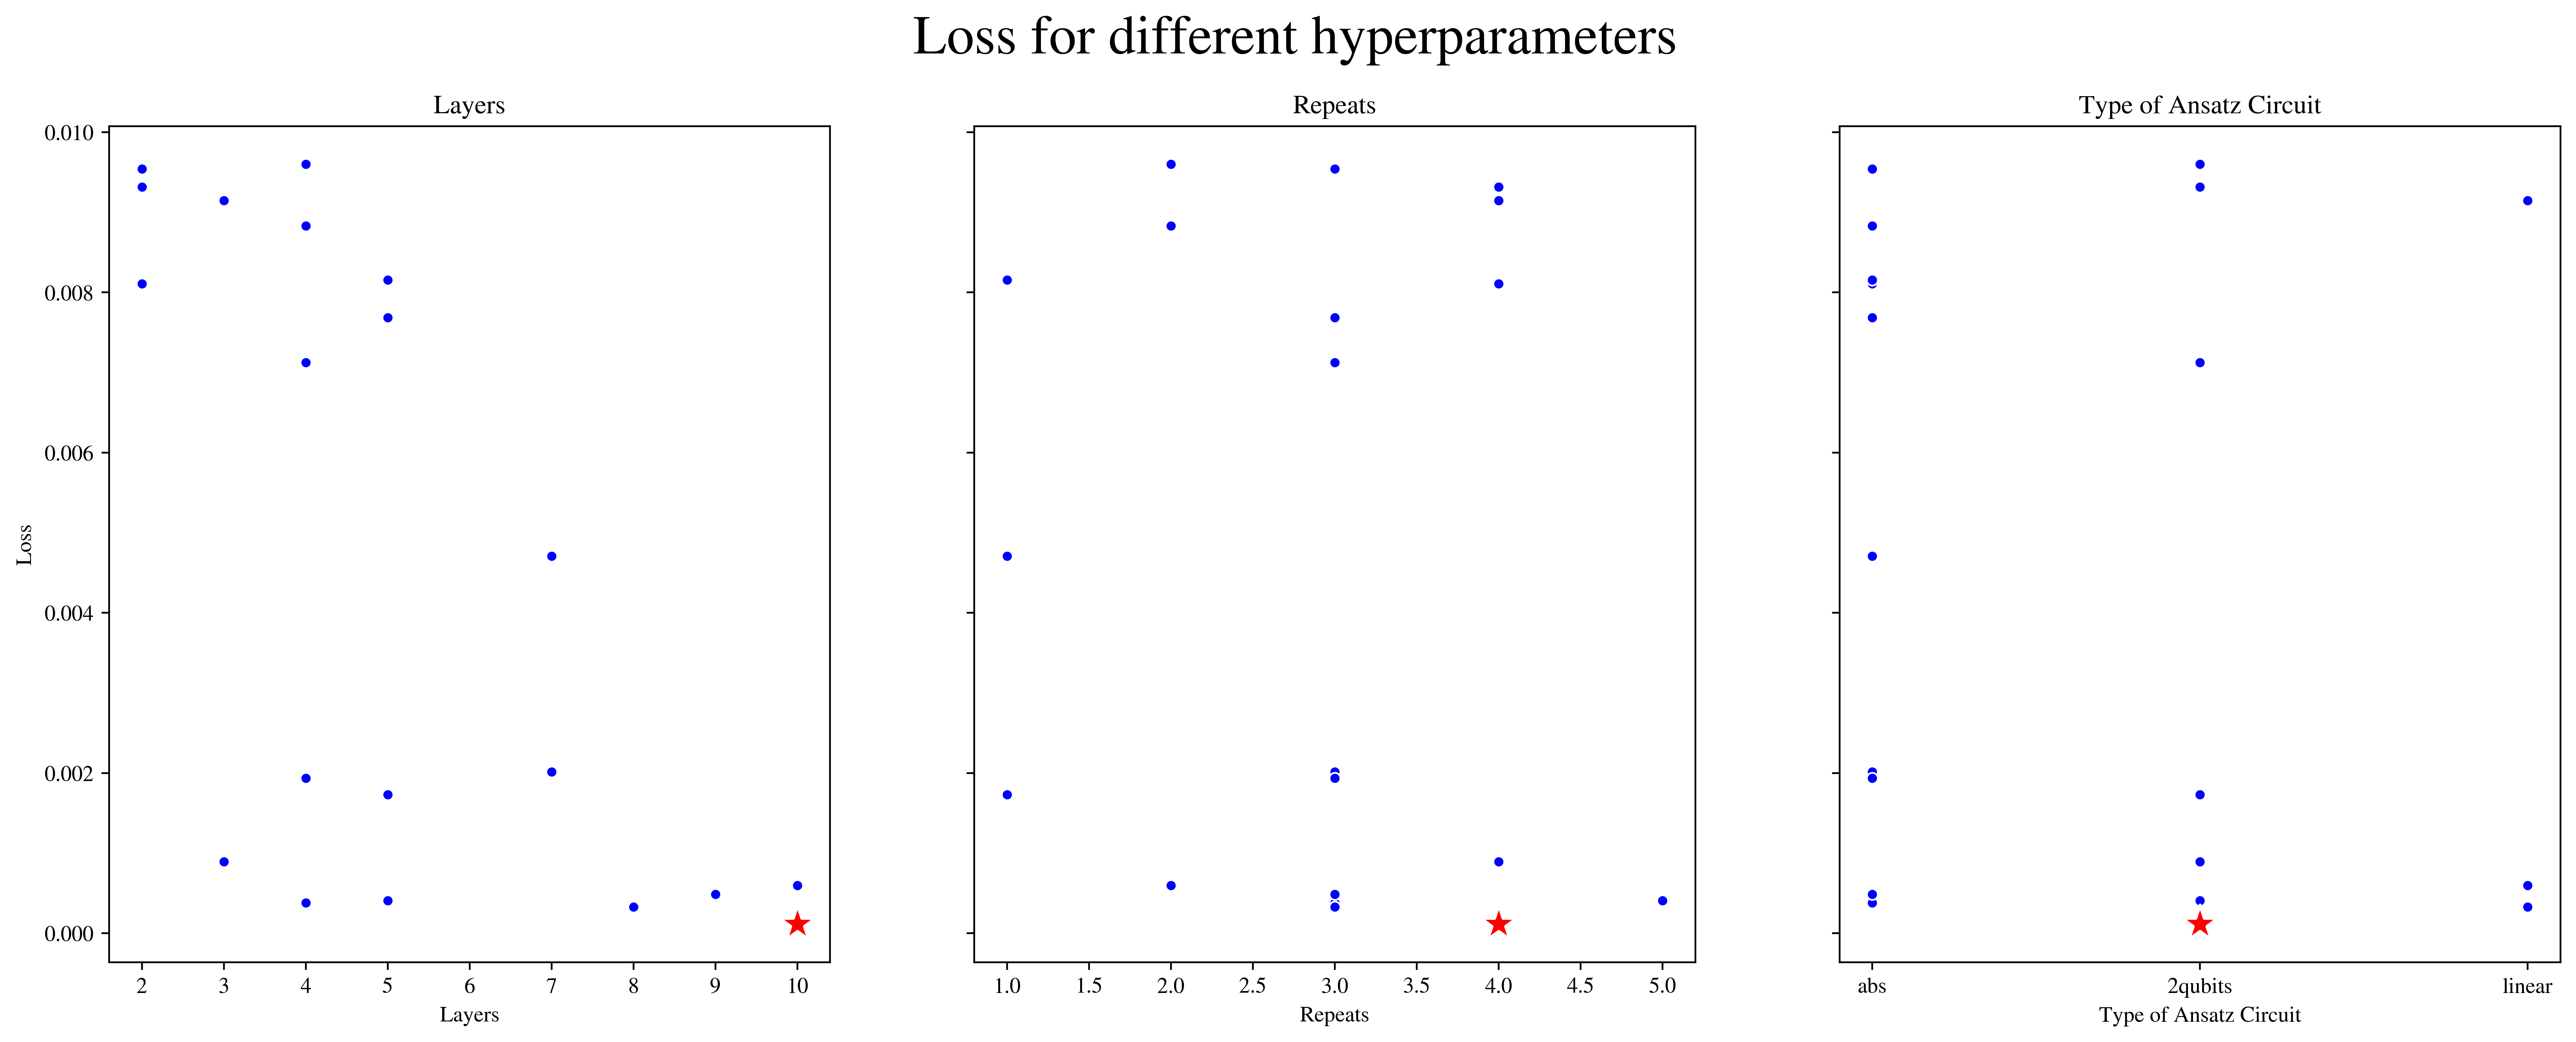

In [13]:
cols = trials_df.columns.drop(["Loss", "LogLoss", "bestParams", "history"])

fig, ax = plt.subplots(1,len(cols), sharey=True, figsize=(20,7), dpi=500)

fig.suptitle("Loss for different hyperparameters", size=25)

for i, hyperParam in enumerate(cols):
    ax[i].set_title(hyperParam)
    sns.scatterplot(data=trials_df, x=hyperParam, y="Loss", ax=ax[i], color="blue", marker=".", s=100)
    sns.scatterplot(data=trials_df.loc[[idx_best],:], x=hyperParam, y="Loss", ax=ax[i], marker="*", color="red", s=300)
    
    #Show trial number
    #[ax[i].annotate(idx, (trials_df.loc[idx,hyperParam], trials_df.loc[idx,"Loss"]), fontsize=8, fontweight="bold") for idx in trials_df.reset_index()["index"].values]#

plt.show()

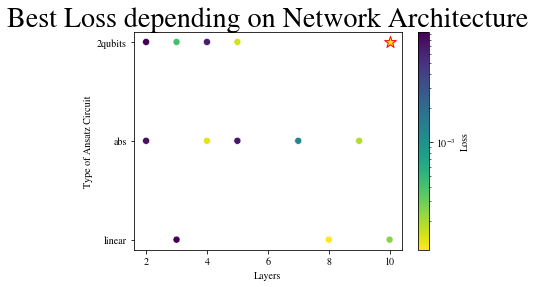

In [15]:
tmp_df = trials_df[["Loss", "LogLoss", "Layers", "Type of Ansatz Circuit"]]
tmp_df = tmp_df.loc[tmp_df.groupby(["Layers", "Type of Ansatz Circuit"])["Loss"].idxmin()]

plt.figure()
plt.title(r"Best Loss depending on Network Architecture", size=28)
sns.scatterplot(data=tmp_df.drop(idx_best, axis=0), x="Layers", y="Type of Ansatz Circuit", hue="LogLoss", palette="viridis_r", s=50);
sns.scatterplot(data=tmp_df.loc[[idx_best],:], x="Layers", y="Type of Ansatz Circuit", hue="LogLoss", palette="viridis_r", marker="*", edgecolor="red", s=150);

#colorbar
norm = matplotlib.colors.LogNorm(tmp_df['Loss'].min(), tmp_df['Loss'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
ax = plt.gca()
ax.get_legend().remove()
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.set_ylabel(r"Loss", rotation=90)

#Show trial index
#[plt.annotate(idx, (tmp_df.loc[idx,"Layers"], tmp_df.loc[idx,"Type of Ansatz Circuit"]), fontsize=7) for idx in tmp_df.reset_index()["index"].values]

plt.show()


___
# Best Model

In [18]:
#Printing Best Trial and Model
print("\nBest Trial:")
display(trials_df.loc[[idx_best], ["Loss",  "Layers", "Type of Ansatz Circuit", "Repeats"]])
print("\n\n")

layers = int(trials_df.loc[idx_best,"Layers"])
ansatzType = trials_df.loc[idx_best,"Type of Ansatz Circuit"]
repeats = int(trials_df.loc[idx_best, "Repeats"])


model, _ = makeCircuitAnsatz(layers=layers,
                               nFeatures=nFeatures,
                               ansatzType=ansatzType,
                               repeats=repeats
                            )

print(model.draw(line_wrap=150), "\n\n")


history = trials_df.loc[idx_best,"history"]

print("Computing Training Loss...")
history["loss"] = [loss(par, model, X_train, y_train, nFeatures, layers, ansatzType, verbose=1) for par in history["params_hist"]]
print("Computing Validation Loss...")
history["val_loss"] = [loss(par, model, X_val, y_val, nFeatures, layers, ansatzType, verbose=1) for par in history["params_hist"]]        
print("Done!")


Best Trial:


,Loss,Layers,Type of Ansatz Circuit,Repeats
3,0.000112,10.0,2qubits,4.0





q0:     ─H──H──H──H──H──H──H──H──RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H──H──H──H──H──H──H──H──H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H──H──H──H──H──H──H──H─ ...
q1:     ─RZ─RY─RZ─RY─RZ─RY─RZ─RY─o────o────o────o────o────o────o────o──RZ─RY─RZ─RY─RZ─RY─RZ─RY───o────o────o────o────o────o────o────o──RZ─RY─RZ─RY─RZ─RY─RZ─RY ...

q0: ... ─H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H──H──H──H──H──H──H──H──H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H──H──H──H──H──H──H──H──H─RZ─H─RY─H─RZ─H─RY─H ...
q1: ... ───o────o────o────o────o────o────o────o──RZ─RY─RZ─RY─RZ─RY─RZ─RY───o────o────o────o────o────o────o────o──RZ─RY─RZ─RY─RZ─RY─RZ─RY───o────o────o────o─── ...

q0: ... ─RZ─H─RY─H─RZ─H─RY─H──H──H──H──H──H──H──H──H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H──H──H──H──H──H──H──H──H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H─RZ─H─RY─H── ...
q1: ... ─o────o────o────o──RZ─RY─RZ─RY─RZ─RY─RZ─RY───o────o────o────o────o────o────o────o──RZ─RY─RZ─RY─RZ─RY─RZ─RY───o────o────o────o────o────o────o────o──RZ─ ...

q0: ... H──H──H─

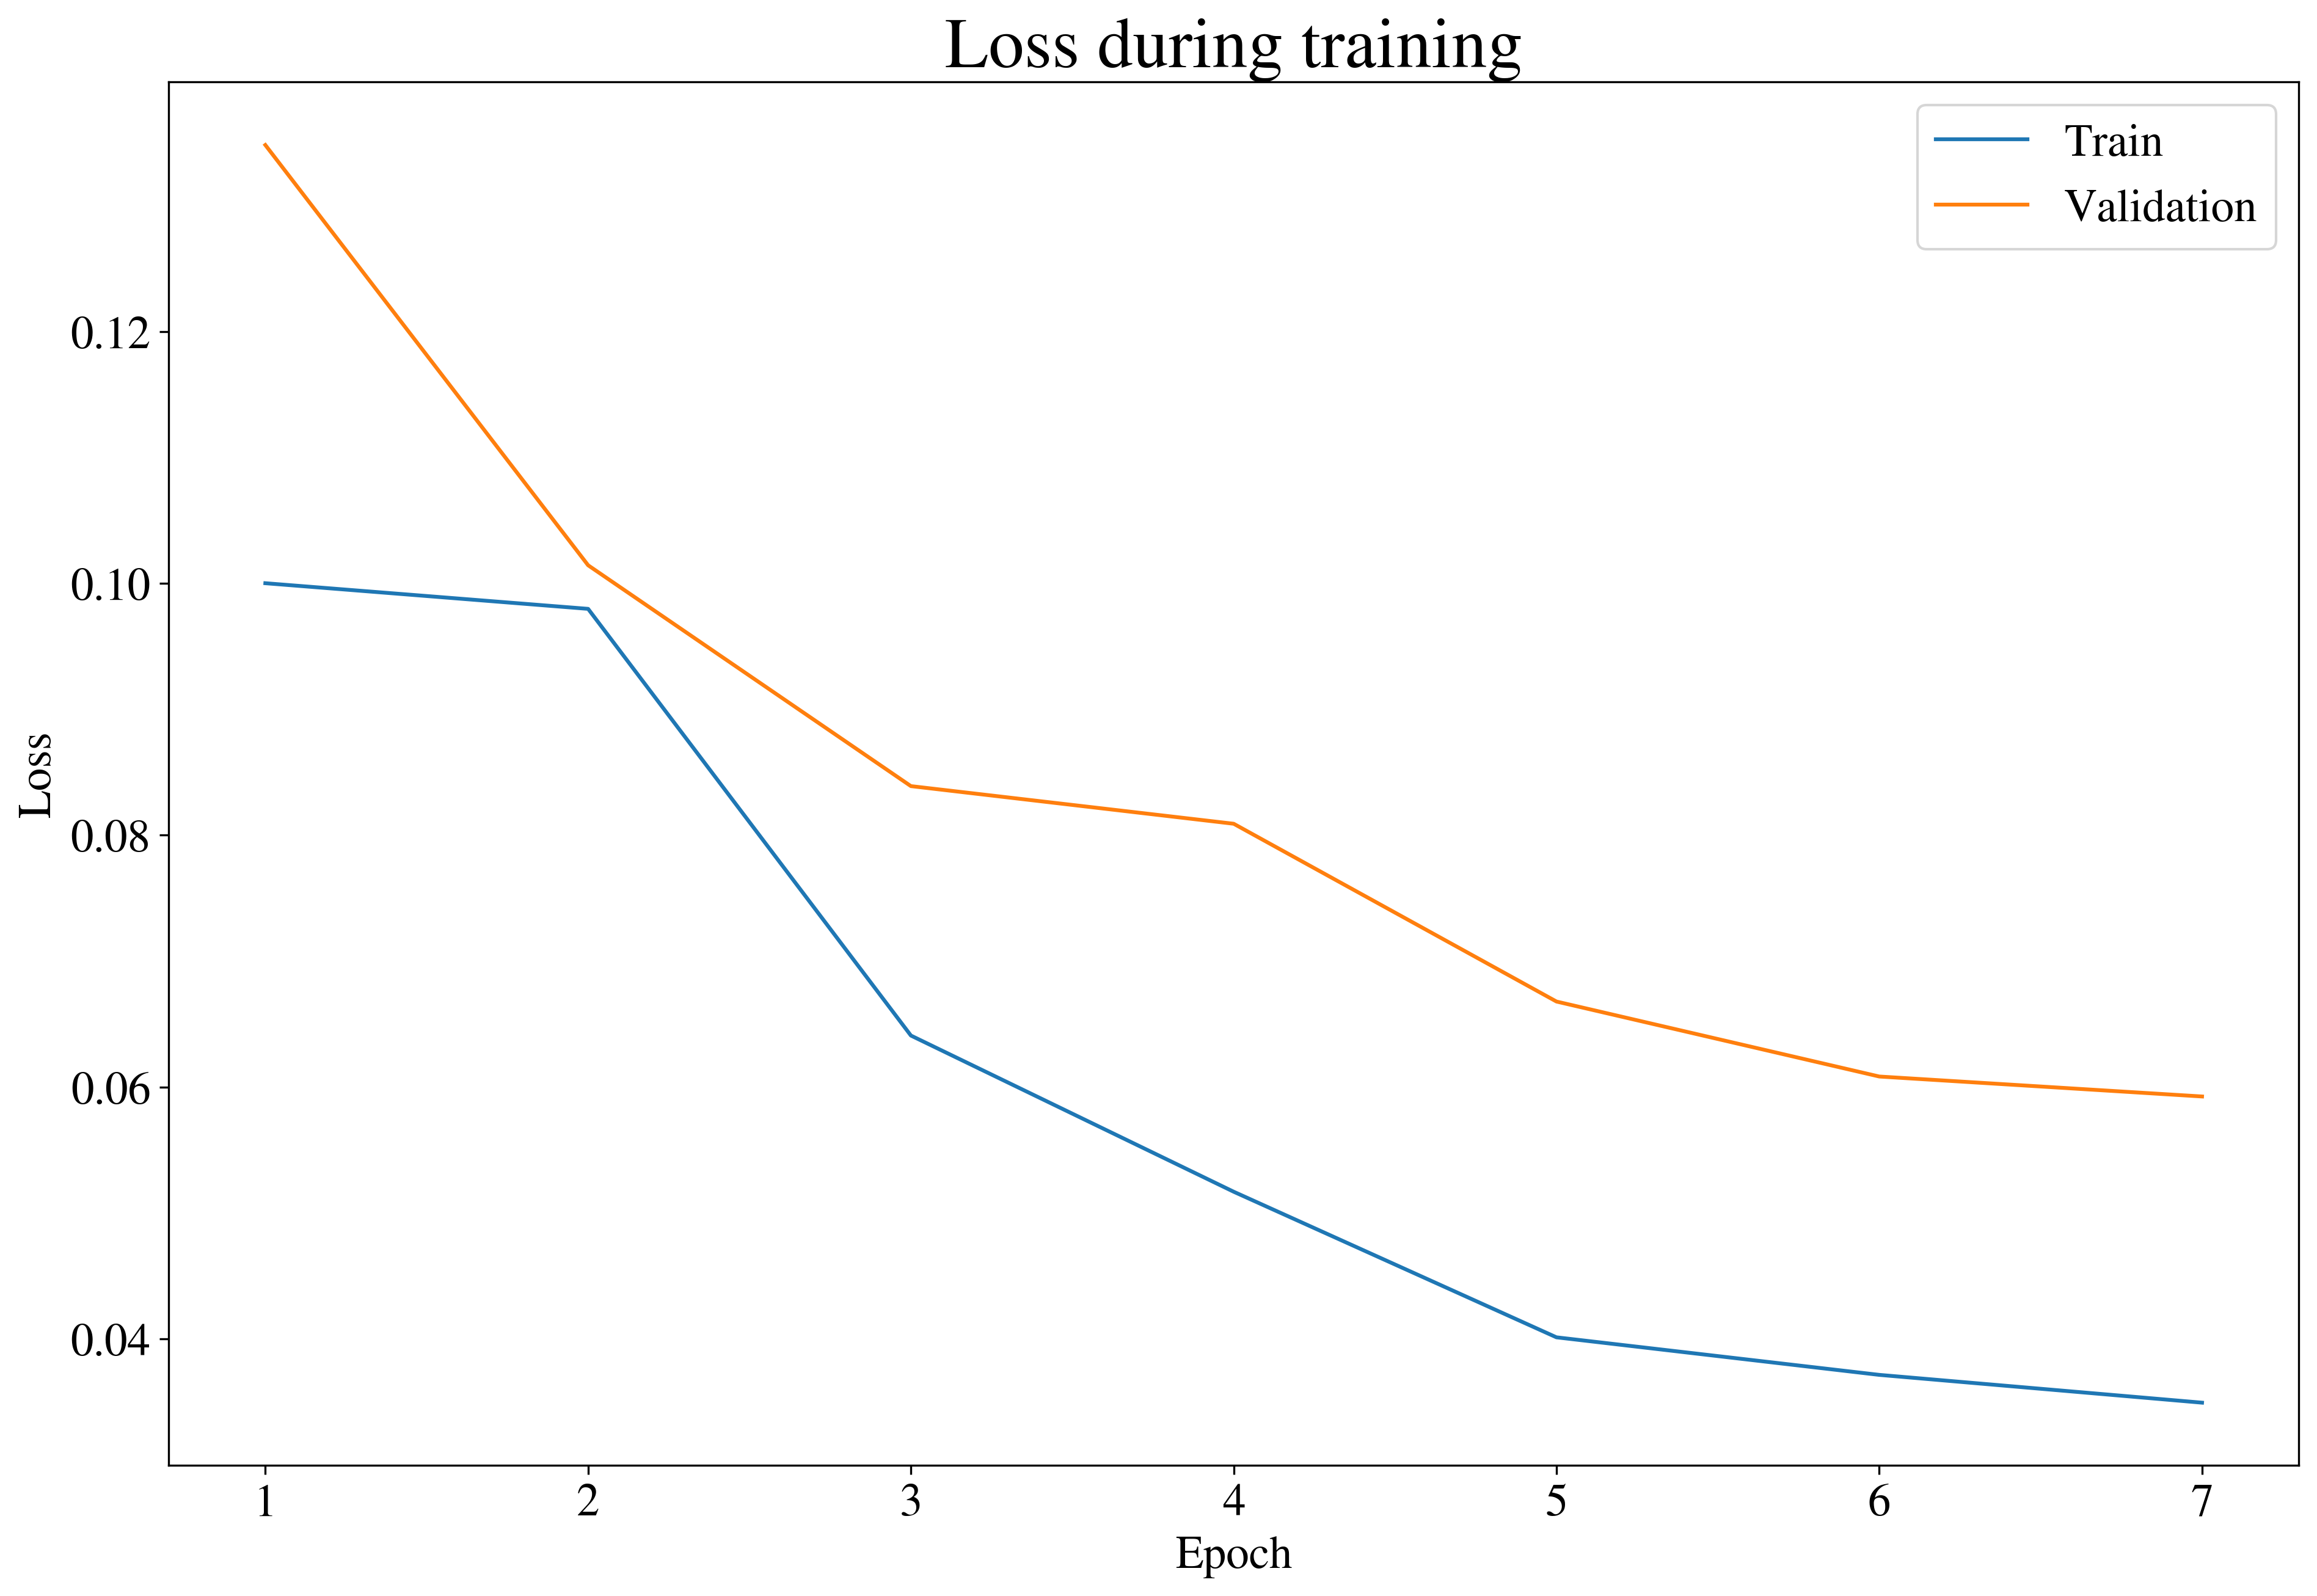

In [65]:
plt.figure()
plt.plot(range(1, len(np.array(history["loss"]))+1), np.array(history["loss"]), label="Train")
plt.plot(range(1, len(np.array(history["loss"]))+1), np.array(history["val_loss"]), label="Validation")
plt.title("Loss during training", size=28)
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.legend()
plt.show()

## Best Model Evaluation

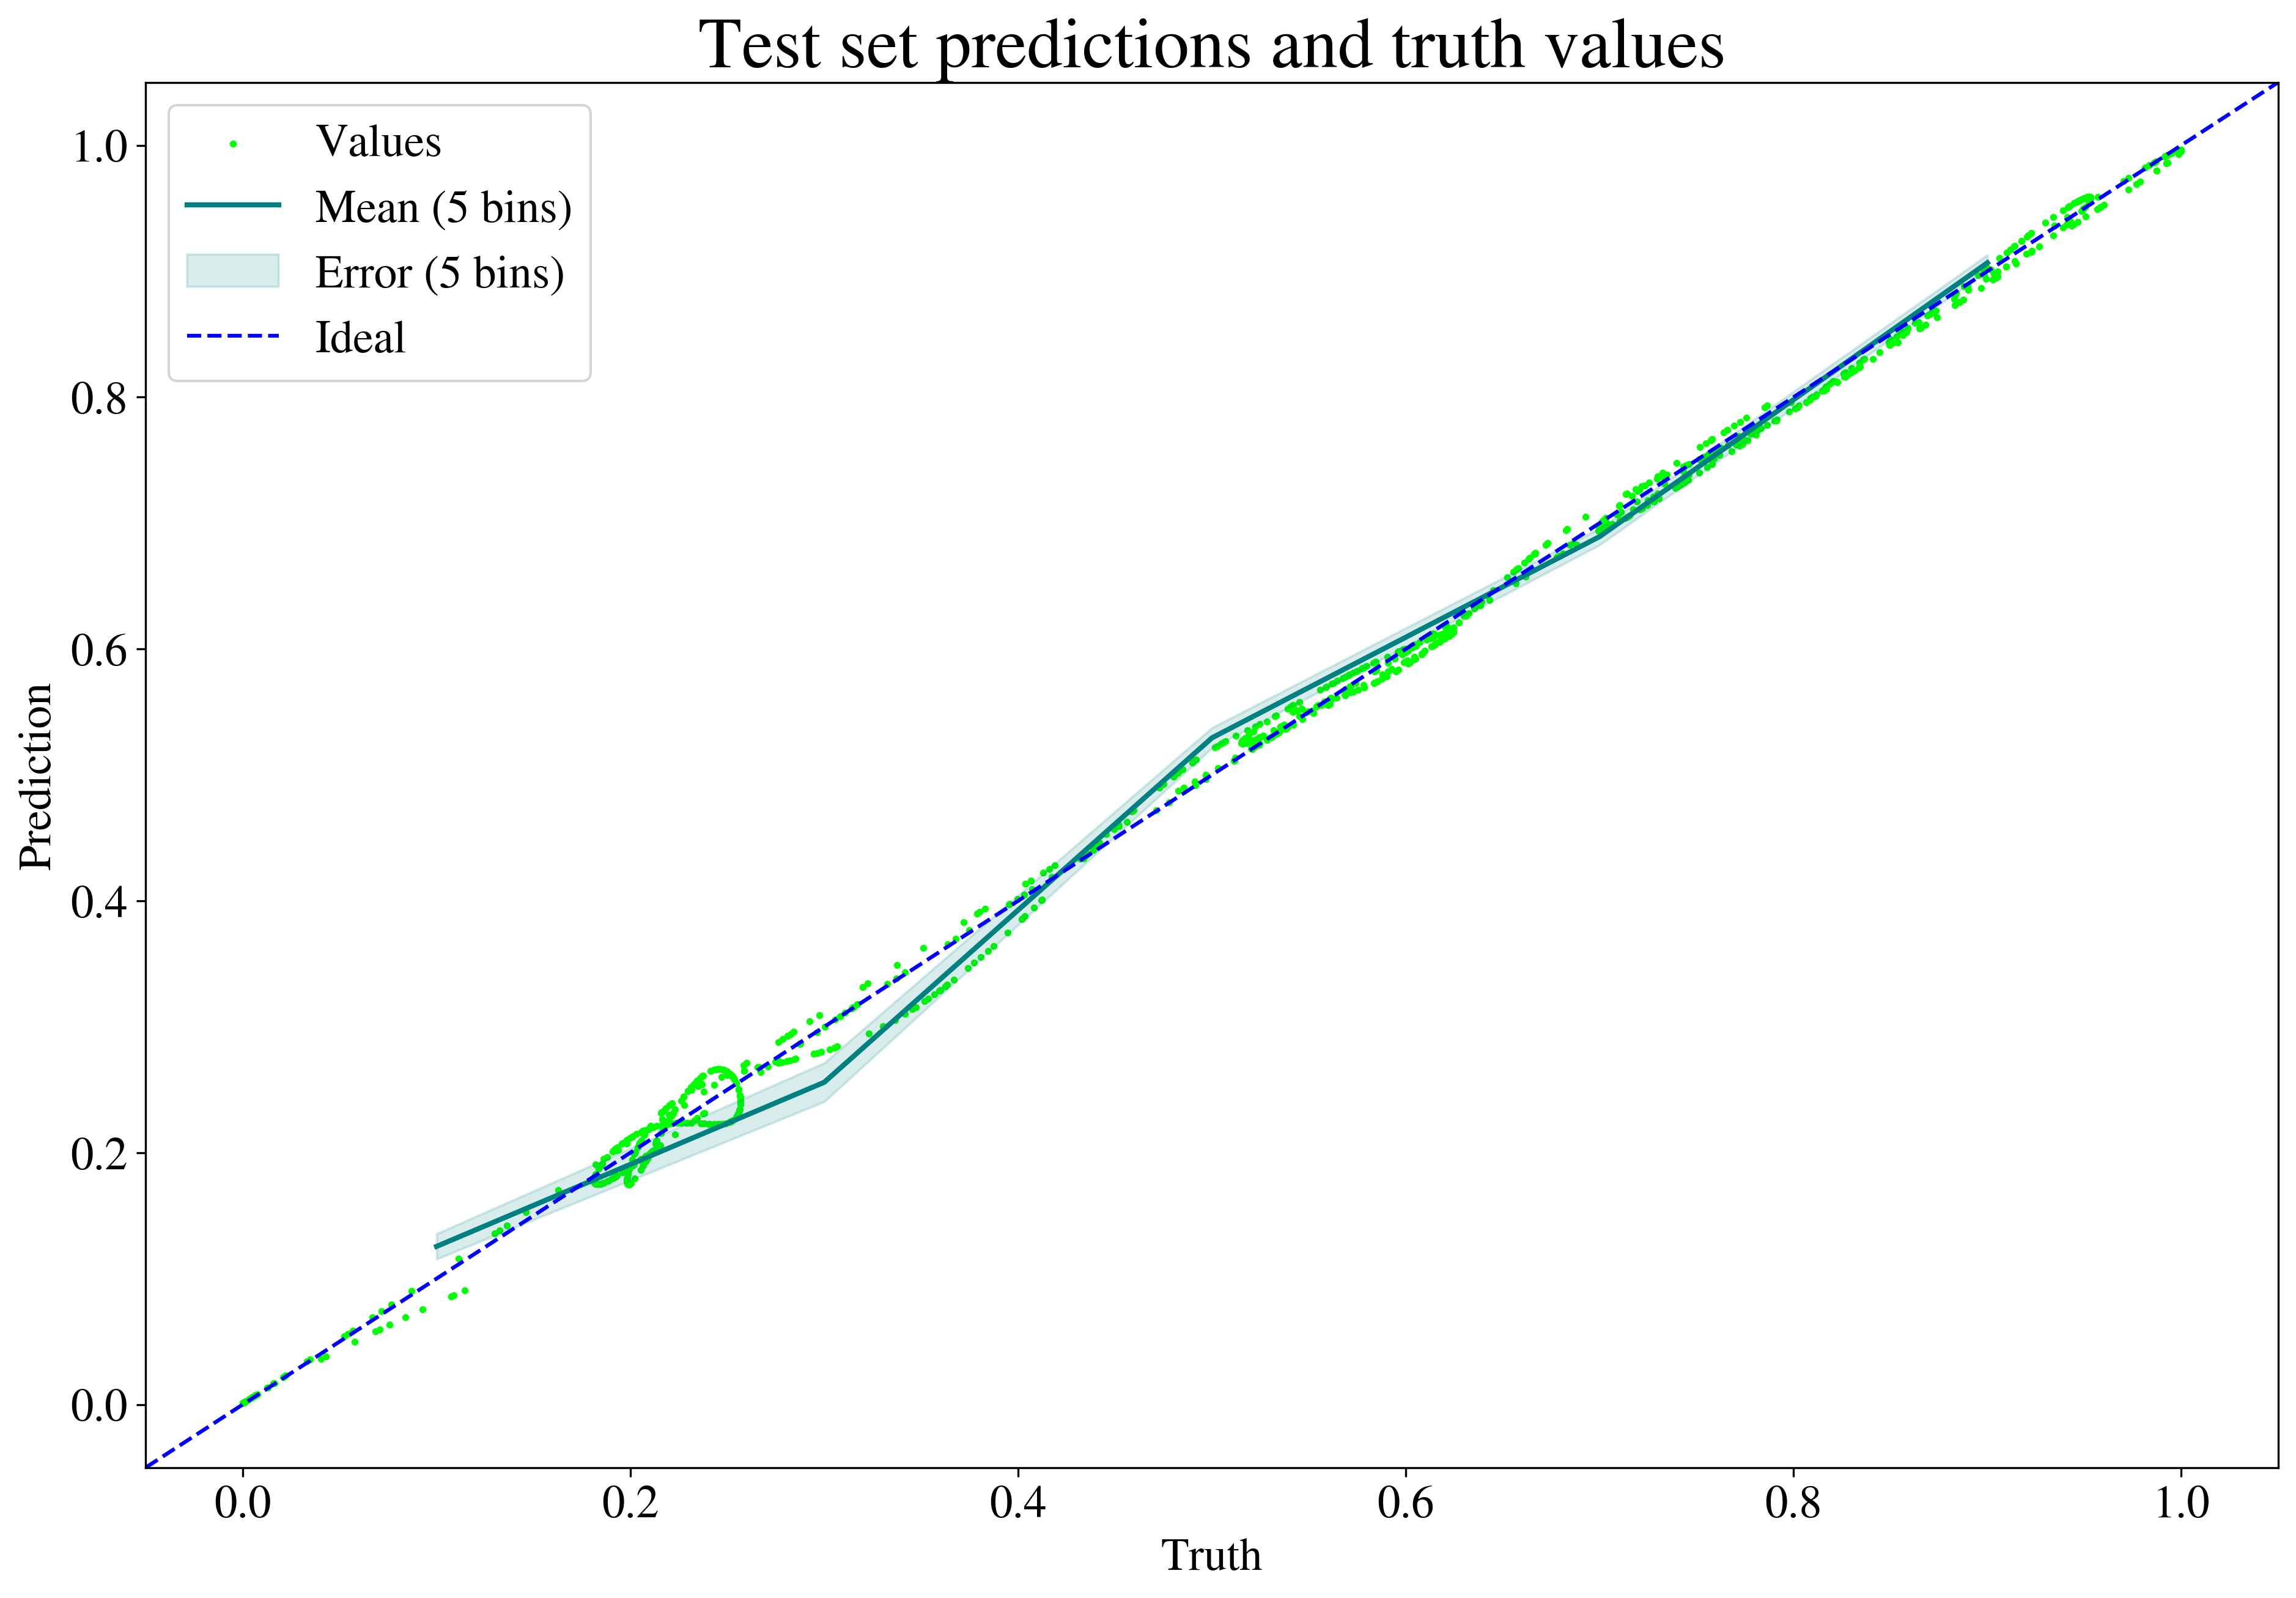

In [25]:
nBins=5
set_name = "Test"

if set_name == "Test":
    yX = [y_test, X_test]
elif set_name == "Validation":
    yX = [y_val, X_val]
elif set_name == "Training":
    yX = [y_train, X_train]
    
y_pred = predict(yX[1], params=trials_df.loc[idx_best,"bestParams"], 
                 nFeatures=nFeatures,
                 ansatzType=trials_df.loc[idx_best,"Type of Ansatz Circuit"],
                 layers=int(trials_df.loc[idx_best,"Layers"]),
                 repeats = int(trials_df.loc[idx_best, "Repeats"])
                )

x = np.linspace(yX[0].min(), yX[0].max(), nBins+1)
x = (x[:-1] + x[1:])/2
mean = binStats(yX[0], y_pred, "mean", bins=nBins).statistic
std = binStats(yX[0], y_pred-yX[0], "std", bins=nBins).statistic


plt.figure()
plt.title(f"{set_name} set predictions and truth values", size=28)

plt.scatter(yX[0], y_pred, s=3, color='lime',label="Values")

plt.plot(x, mean, color="teal", lw=2, label=f"Mean ({nBins} bins)")
plt.fill_between(x, mean-std, mean+std, color="teal", alpha=0.15, label=f"Error ({nBins} bins)")

plt.axline((0,0), (1,1), color="blue", lw=1.5, ls="dashed", label="Ideal")

plt.xlabel('Truth')
plt.ylabel('Prediction')

plt.legend()
plt.show()

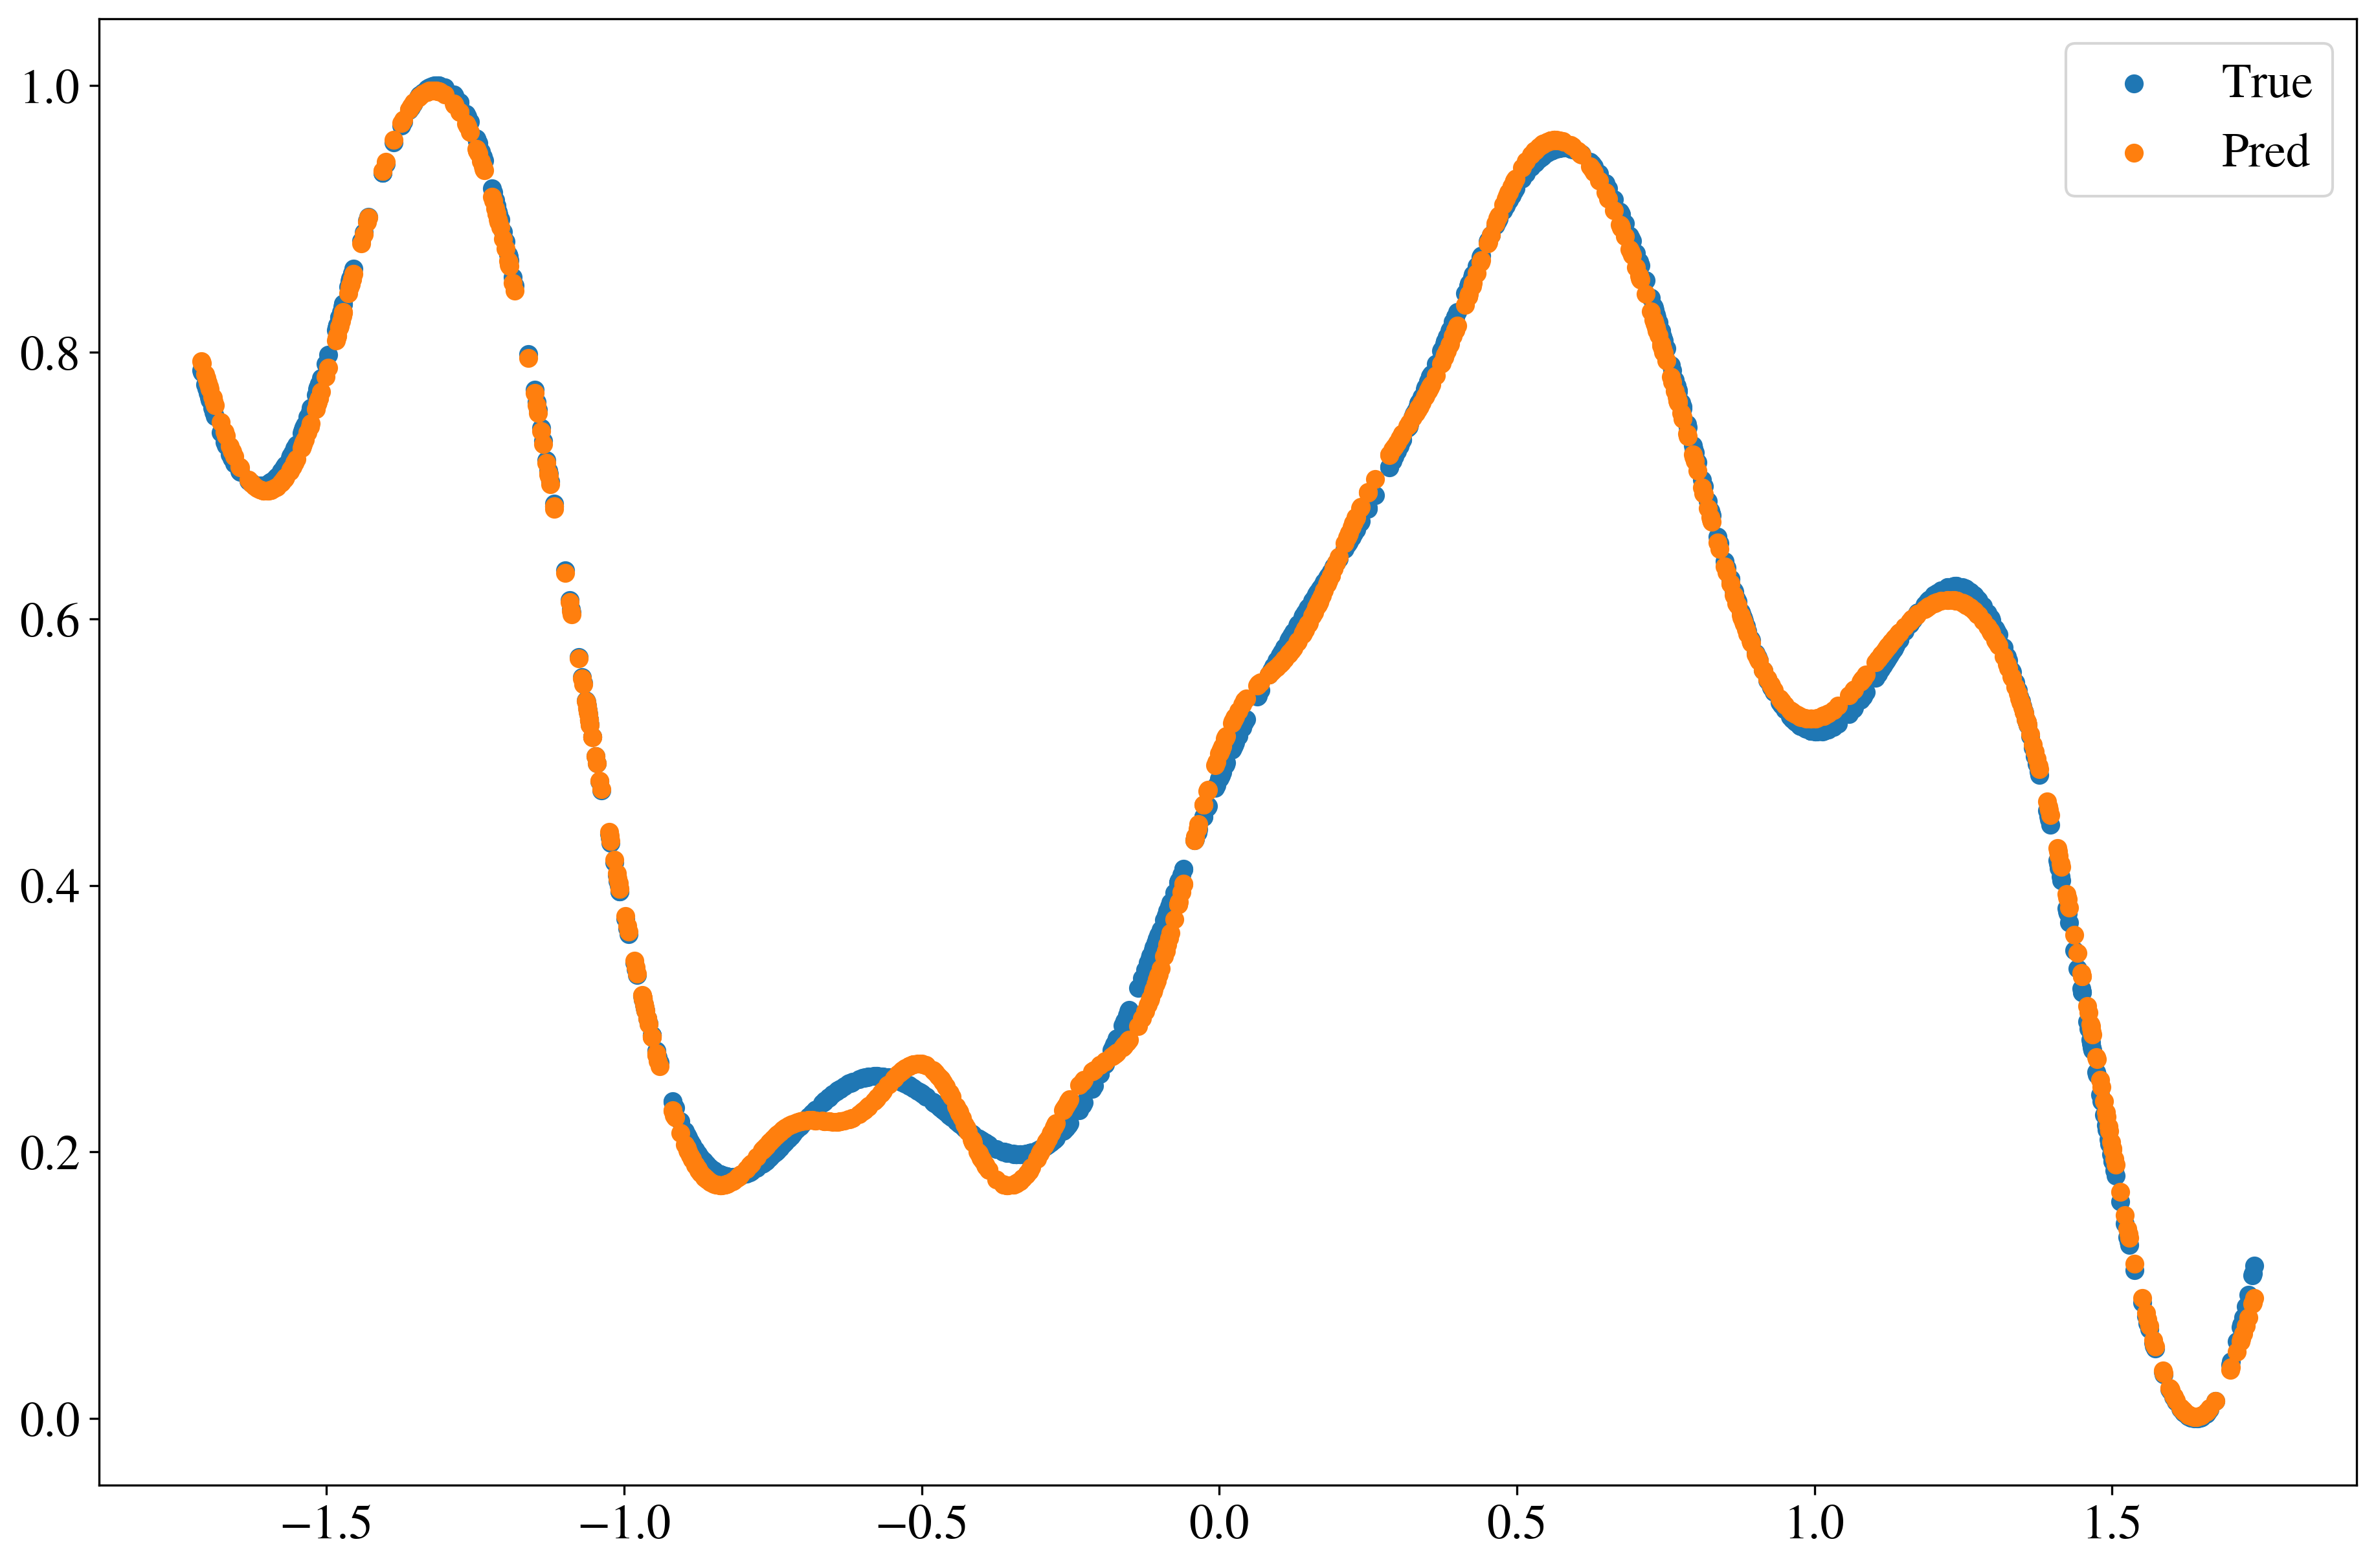

In [27]:
y_pred = predict(X_test, params=trials_df.loc[idx_best,"bestParams"], 
                 nFeatures=nFeatures,
                 ansatzType=trials_df.loc[idx_best,"Type of Ansatz Circuit"],
                 layers=int(trials_df.loc[idx_best,"Layers"]),
                 repeats=int(trials_df.loc[idx_best,"Repeats"])
                )

if nFeatures == 1:
    plt.scatter(X_test, y_test, label="True")
    plt.scatter(X_test, y_pred, label="Pred")
    plt.legend()
if nFeatures == 2:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(X_test[:,0], X_test[:,0], y_test, s=1, marker='.', label="True")
    ax.scatter(X_test[:,0], X_test[:,0], y_pred, s=1, marker='.', label="Pred")
    plt.show()
    
    fig, axs = plt.subplots(1,2, sharey=True)
    for i, ax in enumerate(axs):
        ax.scatter(X_test[:,i], y_test, s=1, marker='.', label="True")
        ax.scatter(X_test[:,i], y_pred, s=1, marker='.', label="Pred")
        ax.set_title(f"Feature {i}")
        ax.set_xlabel(f"x_{i}")
        ax.set_ylabel("y")
    plt.show()

In [161]:
ansatzType = "linear"
layers = 5
epochs = 25

In [162]:
model, _ = makeCircuitAnsatz(layers=layers,
                               n_inputs=nFeatures,
                               ansatzType=ansatzType
                            )

print(model.draw(line_wrap=150))

q0:     ─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY ...

q0: ... ─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─M─


In [165]:
params, history = train(X_train[:100], y_train[:100], layers=layers, ansatzType=ansatzType, nFeatures=nFeatures, epochs=epochs)
history = {"params_hist" : history}

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          180     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27101D-01    |proj g|=  5.54801D-02


 This problem is unconstrained.



At iterate    1    f=  9.77250D-02    |proj g|=  5.00889D-02

At iterate    2    f=  6.89572D-02    |proj g|=  3.54702D-02

At iterate    3    f=  5.08552D-02    |proj g|=  3.81865D-02

At iterate    4    f=  3.69991D-02    |proj g|=  2.12941D-02

At iterate    5    f=  2.97231D-02    |proj g|=  2.01950D-02

At iterate    6    f=  2.43384D-02    |proj g|=  2.08483D-02

At iterate    7    f=  1.95323D-02    |proj g|=  1.30225D-02

At iterate    8    f=  1.54843D-02    |proj g|=  1.07657D-02

At iterate    9    f=  1.35148D-02    |proj g|=  7.11358D-03

At iterate   10    f=  1.19971D-02    |proj g|=  6.37191D-03

At iterate   11    f=  1.09732D-02    |proj g|=  6.36446D-03

At iterate   12    f=  1.03465D-02    |proj g|=  6.34270D-03

At iterate   13    f=  9.80003D-03    |proj g|=  5.00840D-03

At iterate   14    f=  9.32211D-03    |proj g|=  3.03013D-03

At iterate   15    f=  8.98640D-03    |proj g|=  4.16572D-03

At iterate   16    f=  8.66446D-03    |proj g|=  3.18236D-03

At iter

In [ ]:
epochs = len(history["params_hist"])
nParams = len(history["params_hist"][0])
fig, axs = plt.subplots(nParams//3, 3, figsize=(10, 2*(nParams//3)))
fig.suptitle("Parameters during training")
for i in range(nParams):
    p1 = [par[i] for par in history["params_hist"]]
    
    ax = axs[i//3][i%3]
    
    ax.set_title(f"Parameter {i+1}", size=12)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Value")
    ax.scatter(range(1,epochs+1), p1, marker='.', s=10)
    ax.plot(range(1,epochs+1), p1, alpha=0.15)
    #ax.set_yticks([])
    
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)
    ax.yaxis.get_offset_text().set_fontsize(5)
    
    
fig.tight_layout()

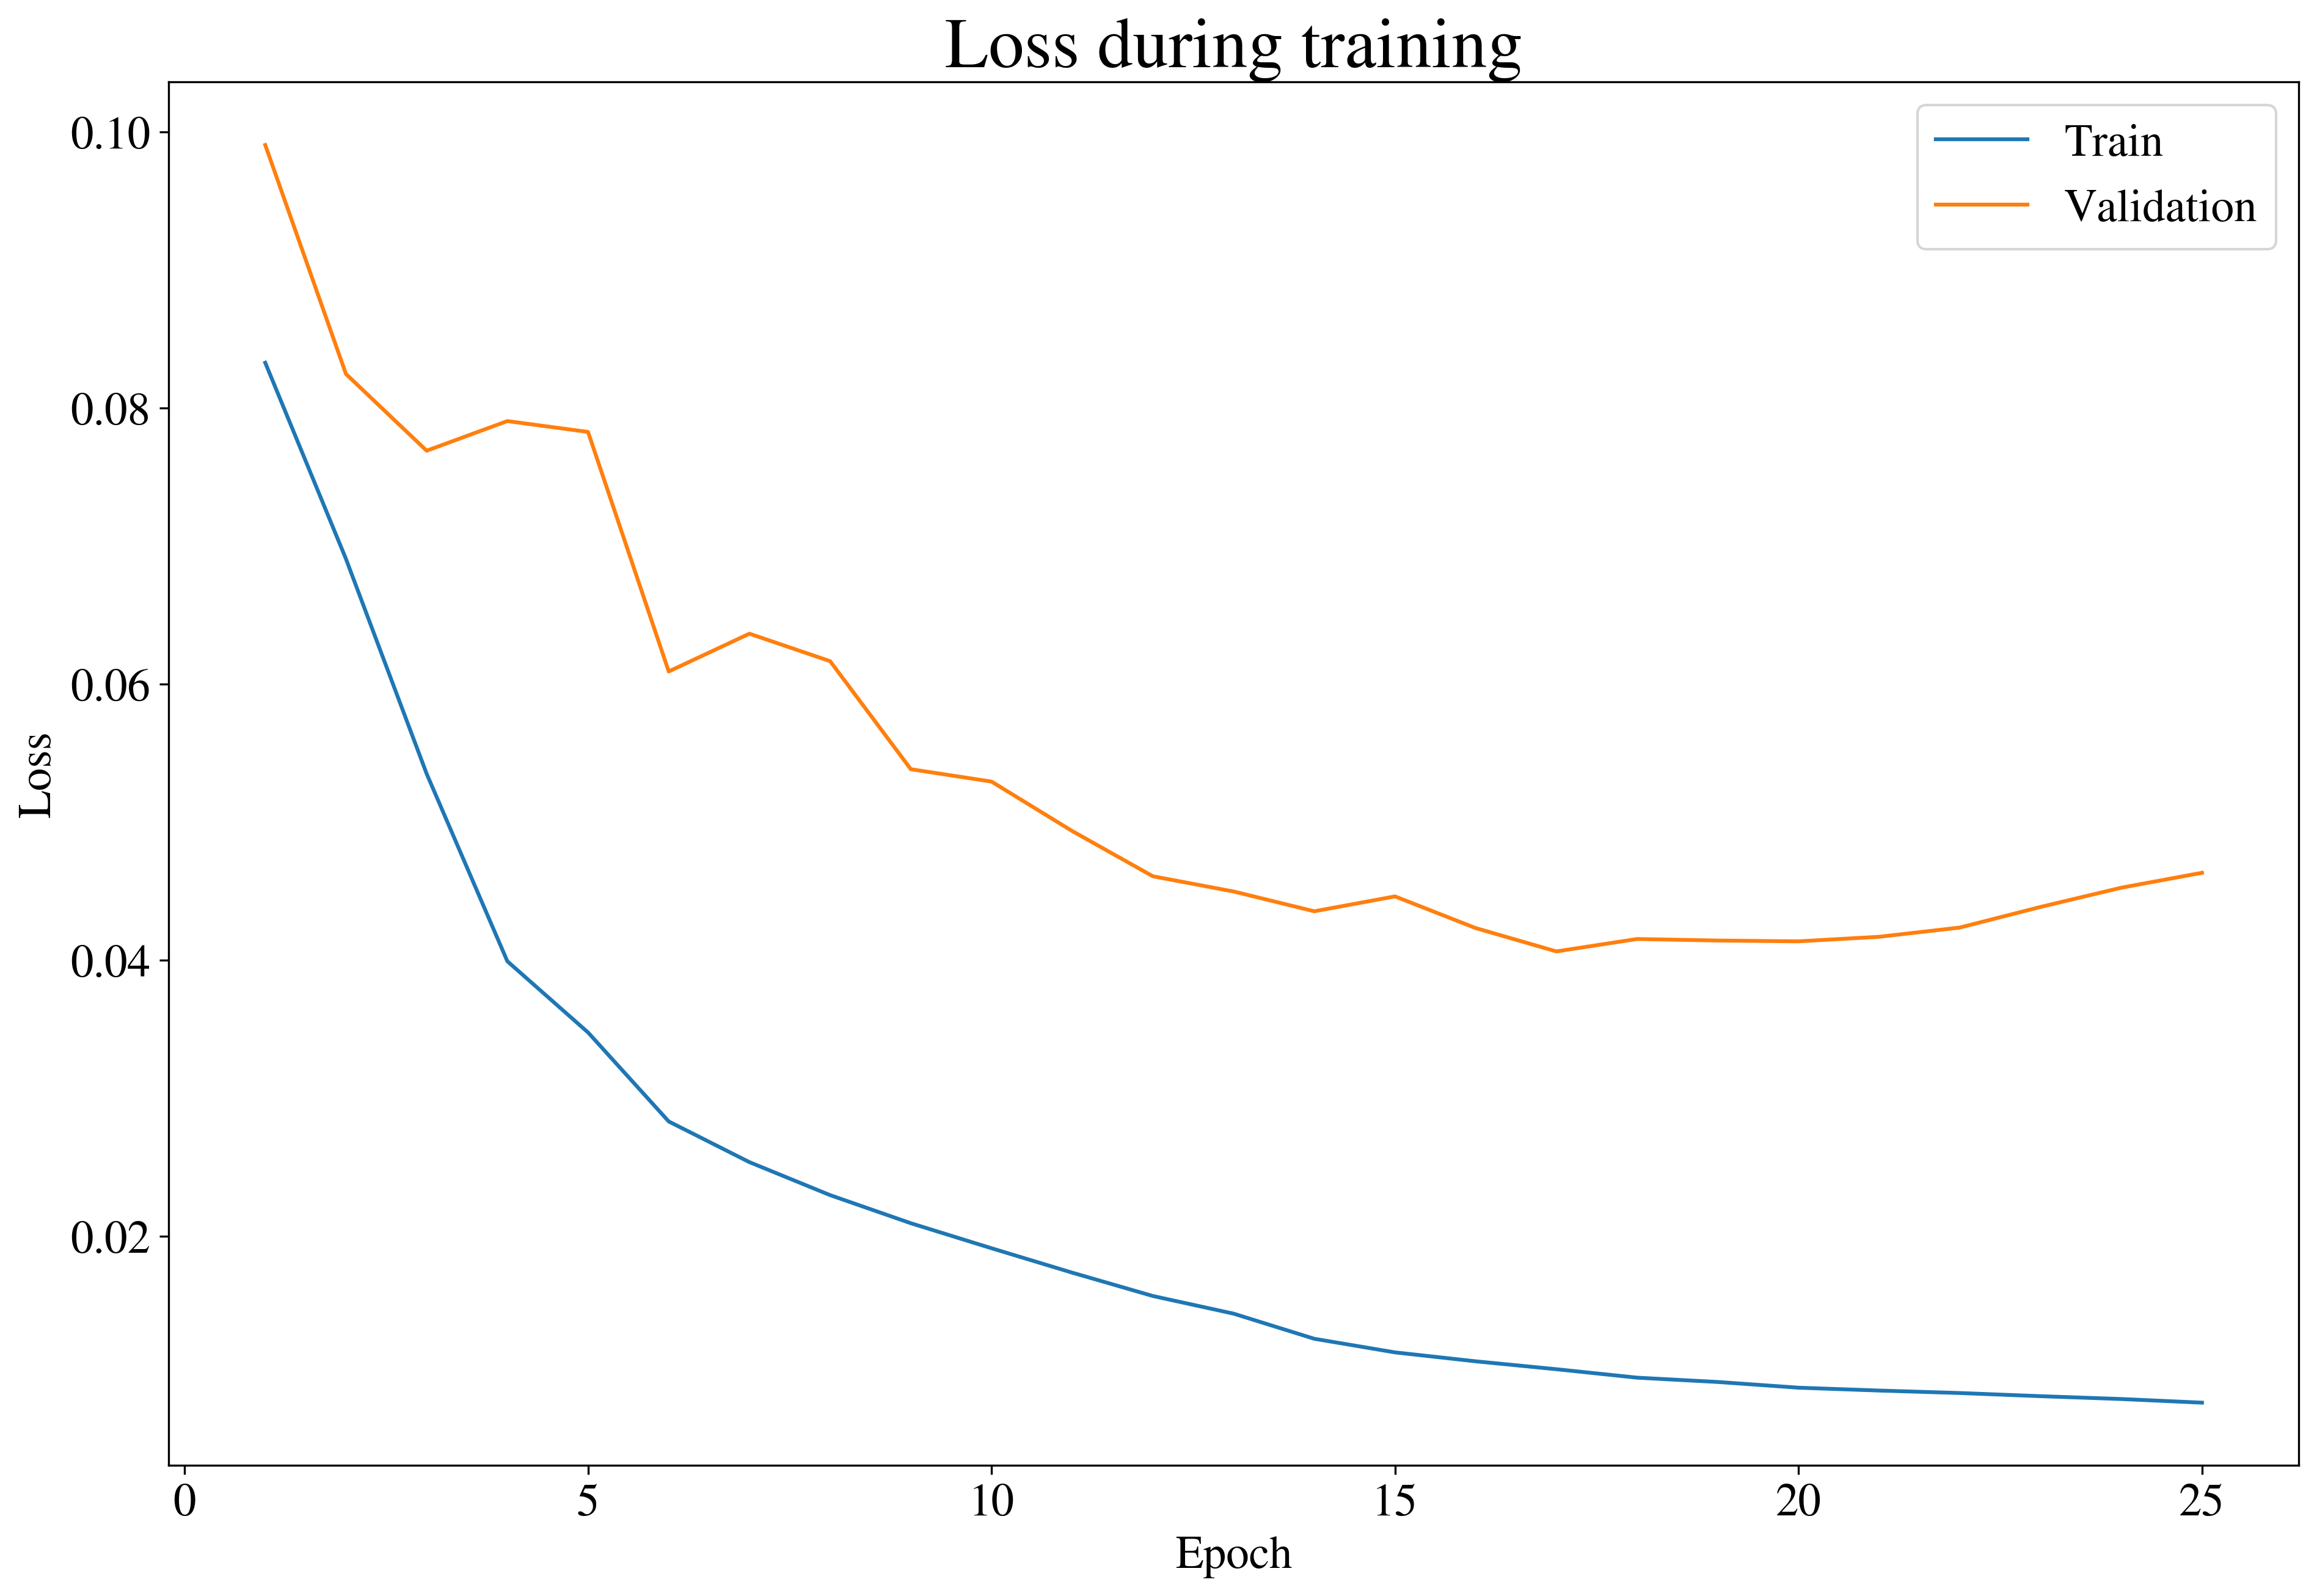

In [157]:
history["loss"] = [loss(par, model, X_train[:100], y_train[:100], nFeatures, layers, ansatzType) for par in history["params_hist"]]
history["val_loss"] = [loss(par, model, X_val[:100], y_val[:100], nFeatures, layers, ansatzType) for par in history["params_hist"]]

plt.figure()
plt.plot(range(1, len(np.array(history["loss"]))+1), np.array(history["loss"]), label="Train")
plt.plot(range(1, len(np.array(history["loss"]))+1), np.array(history["val_loss"]), label="Validation")
plt.title("Loss during training", size=28)
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
if nFeatures == 1:
    plt.scatter(X_test, y_test, label="True")
    plt.scatter(X_test, predict(X_test, params, nFeatures, ansatzType, layers), label="Pred")
    plt.legend()
if nFeatures == 2:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(X_test[:,0], X_test[:,0], y_test, s=1, marker='.', label="True")
    ax.scatter(X_test[:,0], X_test[:,0], predict(X_test, params, nFeatures, ansatzType, layers), s=1, marker='.', label="Pred")

    fig, axs = plt.subplots(1,2, sharey=True)
    for i, ax in enumerate(axs):
        ax.scatter(X_test[:,i], y_test, s=1, marker='.', label="True")
        ax.scatter(X_test[:,i], y_pred, s=1, marker='.', label="Pred")
        ax.set_title(f"Feature {i}")
        ax.set_xlabel(f"x_{i}")
        ax.set_ylabel("y")
    plt.show()

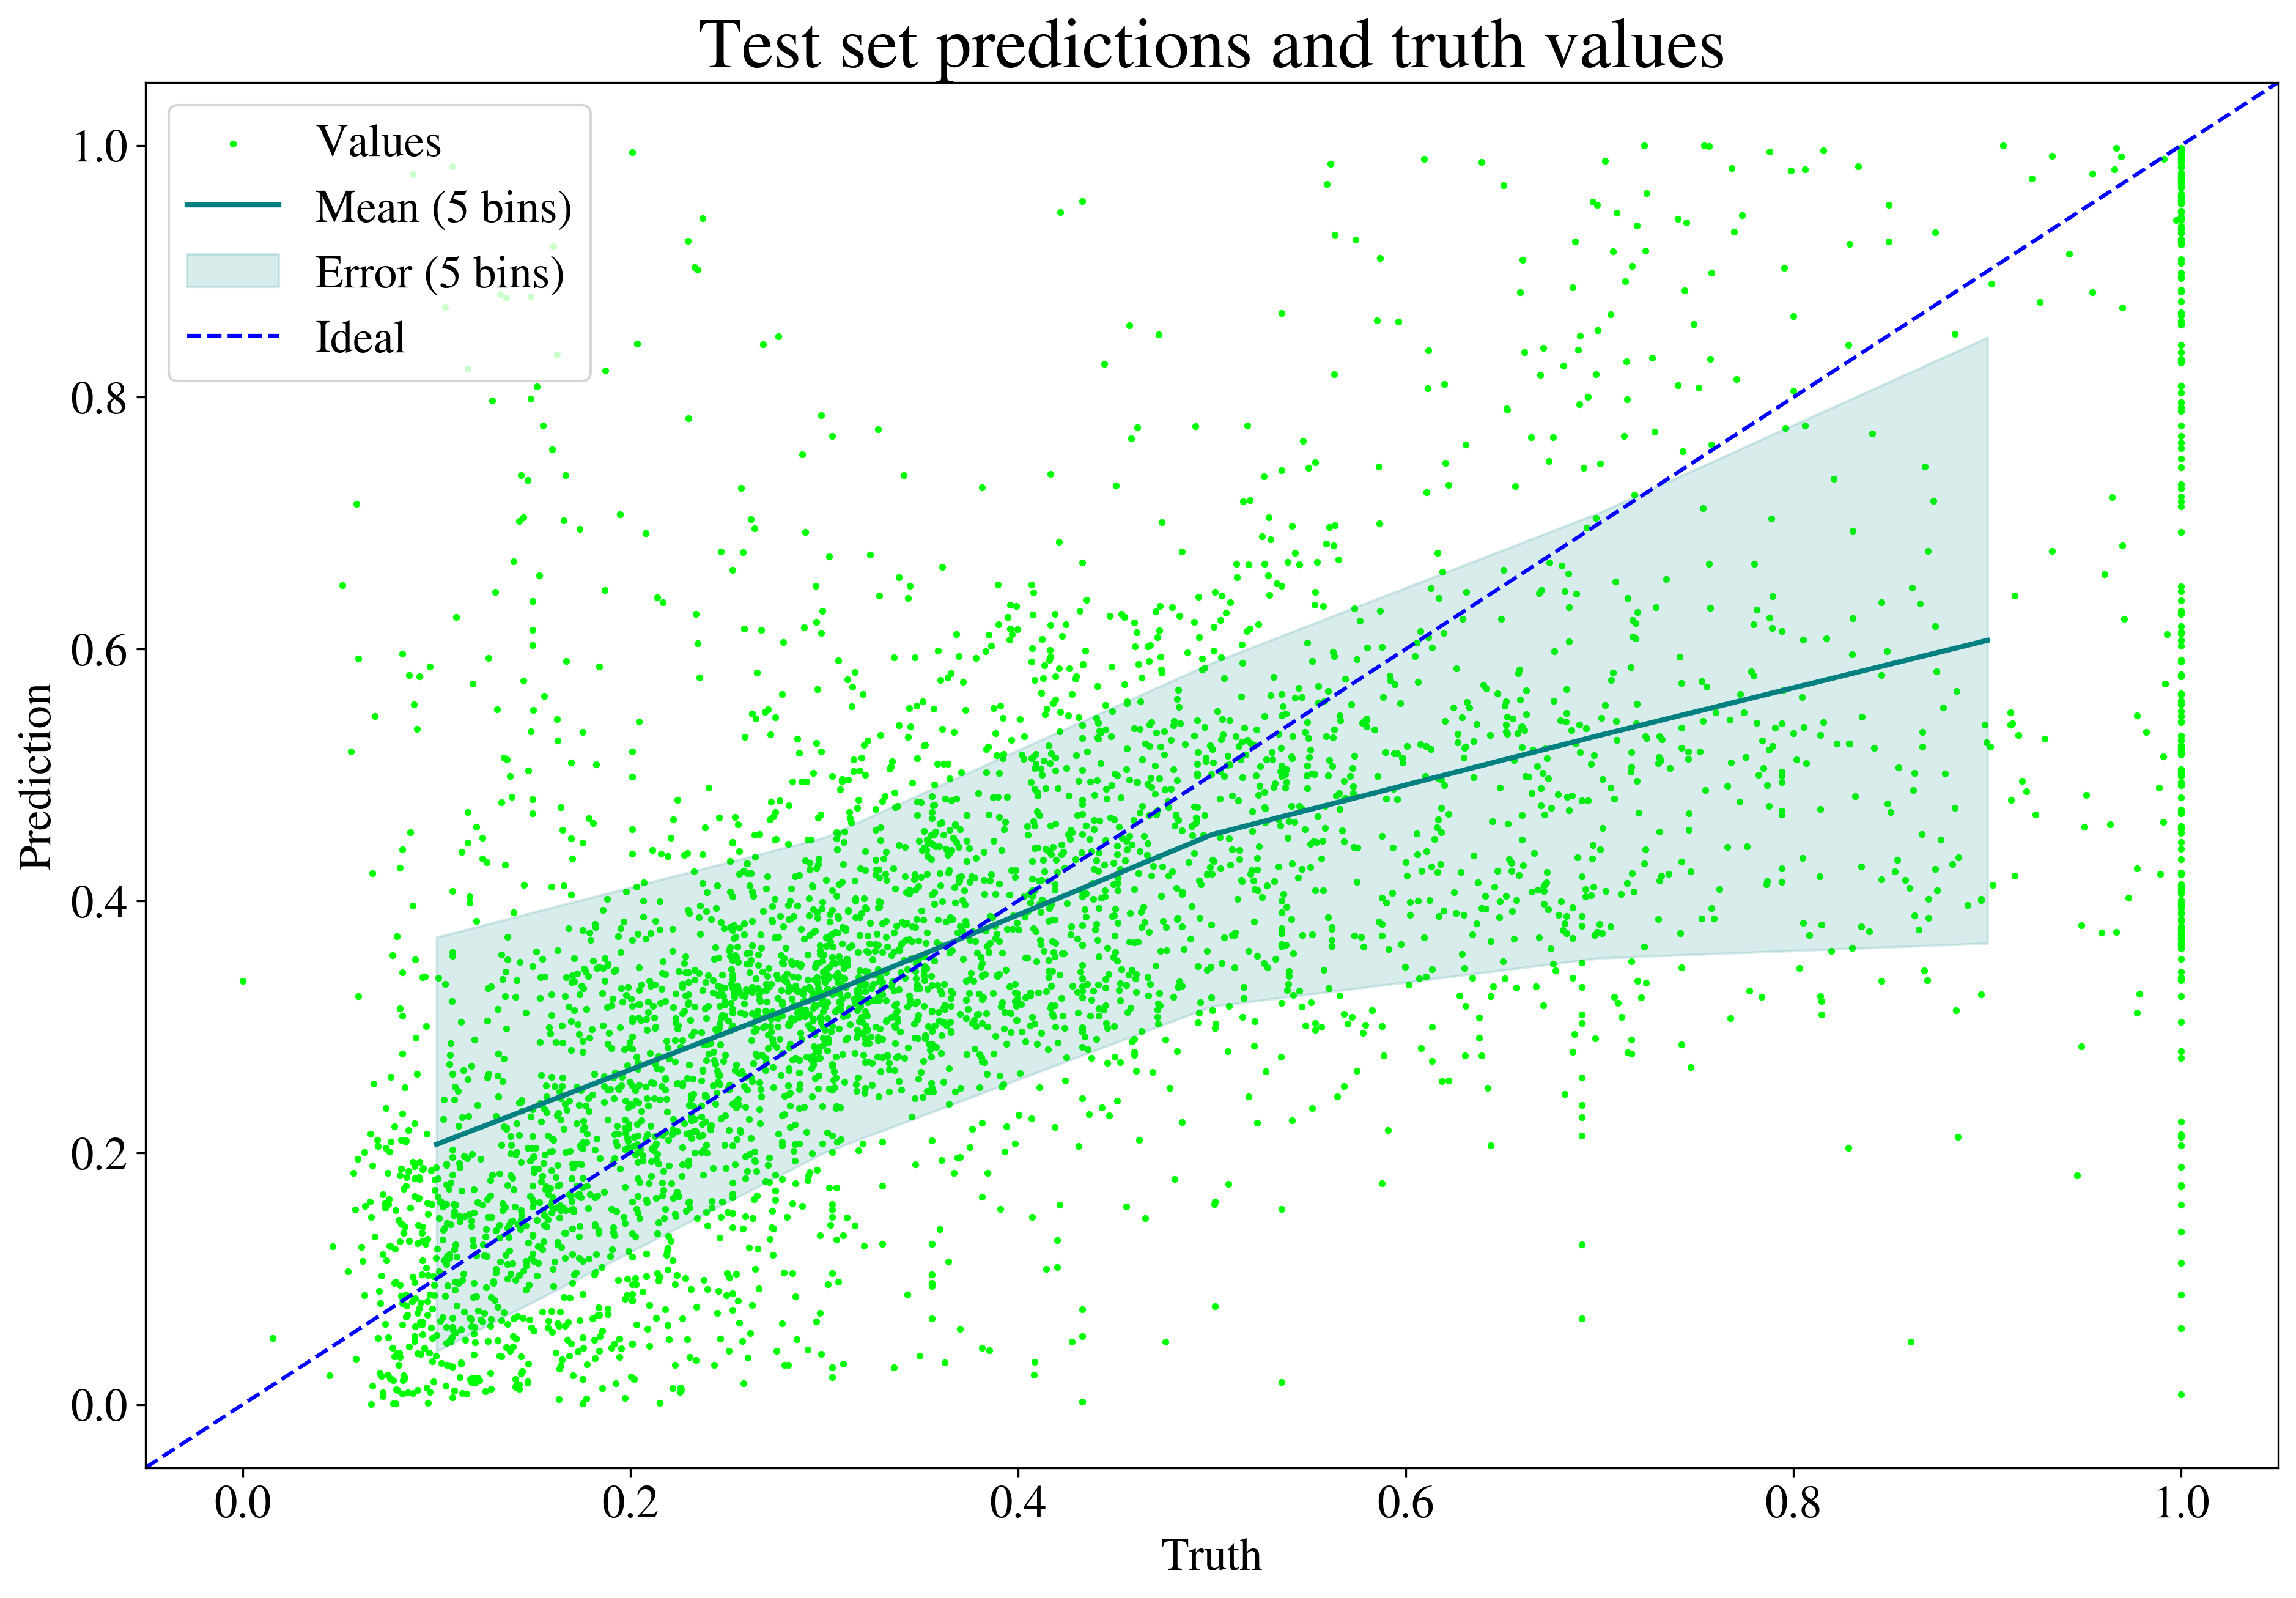

In [160]:
nBins=5
set_name = "Test"


if set_name == "Test":
    yX = [y_test, X_test]
elif set_name == "Validation":
    yX = [y_val, X_val]
elif set_name == "Training":
    yX = [y_train, X_train]
    
y_pred = predict(yX[1], params=params, 
                 nFeatures=nFeatures,
                 ansatzType=ansatzType,
                 layers=layers
                )

x = np.linspace(yX[0].min(), yX[0].max(), nBins+1)
x = (x[:-1] + x[1:])/2
mean = binStats(yX[0], y_pred, "mean", bins=nBins).statistic
std = binStats(yX[0], y_pred-yX[0], "std", bins=nBins).statistic


plt.figure()
plt.title(f"{set_name} set predictions and truth values", size=28)

plt.scatter(yX[0], y_pred, s=3, color='lime',label="Values")

plt.plot(x, mean, color="teal", lw=2, label=f"Mean ({nBins} bins)")
plt.fill_between(x, mean-std, mean+std, color="teal", alpha=0.15, label=f"Error ({nBins} bins)")

plt.axline((0,0), (1,1), color="blue", lw=1.5, ls="dashed", label="Ideal")

plt.xlabel('Truth')
plt.ylabel('Prediction')

plt.legend()
plt.show()